# Neural Network vs. FIR Filter
This notebook shows the equivalence of a neural network with only one causal convolution layer and a FIR filter. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
class CausalConv1d(torch.nn.Conv1d):
    """ Implementation from Alex Rogozhnikov, https://github.com/pytorch/pytorch/issues/1333 """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias)

    def forward(self, input):
        result = super(CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[:, :, :-self.__padding]
        return result

In [3]:
# create a network with only one CausalConv1d layer

class FilterNet(nn.Module):
    def __init__(self):
        super(FilterNet, self).__init__()
        self.layer = CausalConv1d(in_channels=1, out_channels=1, kernel_size=11, bias=False)
        
    def forward(self, x):
        x = self.layer(x)
        return x

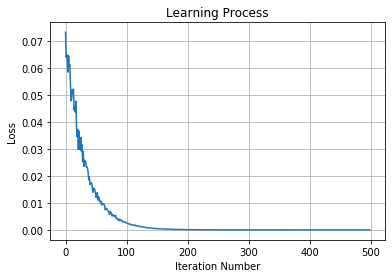

In [4]:
fir_coeffs = np.array([-0.0505, -0.0307, 0.0328, 0.1464, 0.2585,
                       0.3054, 0.2585, 0.1464, 0.0328, -0.0307, -0.0505])

net = FilterNet()
loss_criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

loss_tracker = np.array([])
for _ in range(500):
    
    # generate random input data for training 
    u_train = np.random.rand(1, 1, 1000) - 0.5
    
    # generate output data for training by filtering the input
    # data with the target FIR filter
    y_train_ref = sig.lfilter(fir_coeffs, 1, u_train, axis=2)
    
    optimizer.zero_grad()
    
    y_train = net(torch.from_numpy(u_train).float())
    
    loss = loss_criterion(y_train, torch.from_numpy(y_train_ref).float())
    loss_tracker = np.append(loss_tracker, loss.item())
    loss.backward()
    optimizer.step()

plt.plot(loss_tracker)
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.title("Learning Process")
plt.grid(True)
plt.show()

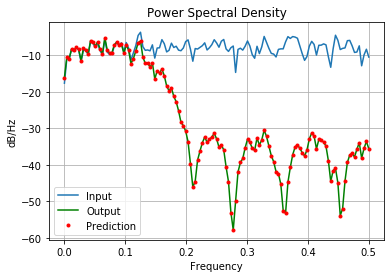

In [5]:
# compare the magnitude response of the target FIR filter
# with the magnitude response of the network

f, pxx_u = sig.welch(u_train.squeeze(), axis=0)
f, pxx_y_ref = sig.welch(y_train_ref.squeeze(), axis=0)
f, pxx_y = sig.welch(y_train.squeeze().data.numpy(), axis=0)
plt.plot(f, 10*np.log10(pxx_u))
plt.plot(f, 10*np.log10(pxx_y_ref), "g")
plt.plot(f, 10*np.log10(pxx_y), "r.")
plt.title("Power Spectral Density")
plt.ylabel("dB/Hz")
plt.xlabel("Frequency")
plt.grid(True)
plt.legend(["Input", "Output", "Prediction"])
plt.show()

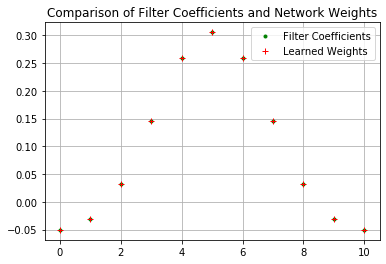

In [6]:
# compare the coefficients of the tagret FIR filter with
# the weights of the network

plt.plot(fir_coeffs, "g.")
plt.plot(net.layer.weight.data.numpy().squeeze(), "r+")
plt.grid(True)
plt.legend(["Filter Coefficients", "Learned Weights"])
plt.title("Comparison of Filter Coefficients and Network Weights")
plt.show()

It can be seen that after training the network, the magnitude response of the network is equal to the magnitude response of the FIR filter. By looking at the networks weights, it can be seen that the converged to the values of the FIR filter coefficients.